In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GRU, Embedding, Input, concatenate, Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, roc_curve

## Preprocess

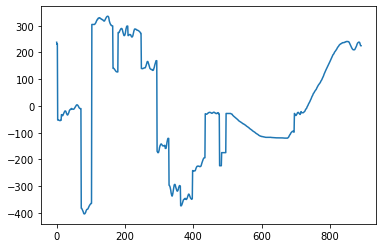

In [2]:
import sys
sys.path.append("../..")
from data import preprocess
data = preprocess.preprocess('../../data/raw/CD_PD.mat')
label = data['diagnosis'].astype('int32')

def normalize_mean(data):
    for i in range(len(data)):
        data[i] = data[i] - np.mean(data[i])
    return data

# Normalize Mean
data_x = normalize_mean(data['x'])
data_y = normalize_mean(data['y'])
data_p = normalize_mean(data['p'])

plt.plot(data['x'][0])

## FFT

In [4]:
WINDOW_SIZE = 30

def signal_fft(signal):
    res = []
#     plt.figure(figsize=(15,5))
    for i in range(0, len(signal) - WINDOW_SIZE):
        sig_fft = np.absolute(np.fft.fft(signal[i: i + WINDOW_SIZE]))
        res.append(sig_fft)
#         plt.plot(sig_fft)
#     plt.show()
    return res

def signal_fft_component(signal, pt, plot=False, n_lines=10):
    res, temp = [], []
    c = 0
    if plot: 
        plt.figure(figsize=(13, 4))
        plt.xlim(0, 50)
        plt.ylim(-10, 10)
    for i in range(len(signal)):
        if pt[i] != 2:
            if len(temp) > WINDOW_SIZE:
                sig_fft = np.absolute(np.fft.fft(temp))
                res.append(sig_fft[:WINDOW_SIZE])
                if plot and c < n_lines: 
                    plt.plot(sig_fft)
                    c += 1
            temp = []
        else:
            temp.append(signal[i])
    if plot: plt.show()
    return res

# Non PD
# signal_fft_component(data['p'][0], data['pt'][0], True)
# signal_fft_component(data['p'][55], data['pt'][55], True)

# PD
# signal_fft_component(data['p'][191], data['pt'][191], True)
# signal_fft_component(data['p'][170], data['pt'][170], True)

signal_fft(data['p'][0])
signal_fft(data['p'][170])

[array([3.29583752, 2.61816506, 1.60799967, 1.26010575, 1.0213349 ,
        0.66805416, 0.40713634, 0.29010556, 0.28626133, 0.3223483 ,
        0.30640855, 0.29710569, 0.25638704, 0.21563637, 0.17679322,
        0.15876896, 0.17679322, 0.21563637, 0.25638704, 0.29710569,
        0.30640855, 0.3223483 , 0.28626133, 0.29010556, 0.40713634,
        0.66805416, 1.0213349 , 1.26010575, 1.60799967, 2.61816506]),
 array([3.04864651, 2.86086966, 1.8551439 , 1.49701047, 1.2411555 ,
        0.86783735, 0.57747664, 0.33850294, 0.20518498, 0.15482696,
        0.07651064, 0.04995979, 0.03878658, 0.06060276, 0.07890764,
        0.08842205, 0.07890764, 0.06060276, 0.03878658, 0.04995979,
        0.07651064, 0.15482696, 0.20518498, 0.33850294, 0.57747664,
        0.86783735, 1.2411555 , 1.49701047, 1.8551439 , 2.86086966]),
 array([3.2039958 , 2.70558025, 1.7156532 , 1.40484568, 1.20354163,
        0.88416778, 0.64437304, 0.46933114, 0.3600338 , 0.2979779 ,
        0.18969108, 0.12536666, 0.13061241, 

In [7]:
def signal_preprocess(data, label, pt_data):
    X_data, y_data = [], []
    for i in range(len(data)):
        fft_com = signal_fft(data[i])
        X_data += fft_com
        y_data += [label[i]] * len(fft_com)      
    return np.array(X_data), np.array(y_data)

X_data, y_data = signal_preprocess(data['p'], label, data['pt'])

In [8]:
print(X_data.shape, y_data.shape)

(180909, 30) (180909,)


In [9]:
from tensorflow.keras.layers import *

In [10]:
def get_cnn_model(window_size):
    adam = Adam(lr=1e-4)
    model = Sequential()
    model.add(Conv1D(16, kernel_size=5,input_shape=(window_size,1)))
    model.add(MaxPooling1D(pool_size=6, padding='same'))
    model.add(Conv1D(16, kernel_size=5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=adam)
    return model

model = get_cnn_model(WINDOW_SIZE)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 26, 16)            96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1296      
_________________________________________________________________
dense (Dense)                (None, 1, 128)            2176      
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 32)             4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 32)             0

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
# Split train test
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)
X_train = X_train.reshape(*X_train.shape,1)
X_test = X_test.reshape(*X_test.shape,1)
model = get_cnn_model(WINDOW_SIZE)
es = EarlyStopping(monitor='val_loss', mode='min',patience=20)
history = model.fit(X_train, y_train, batch_size=100,
    epochs=500, verbose=1, validation_data=(X_test, y_test), callbacks=[es])
model.evaluate(X_test, y_test)

Train on 144727 samples, validate on 36182 samples
Epoch 1/500
144727/144727 [==============================] - 4s 29us/sample - loss: 0.6530 - val_loss: 0.6422
Epoch 2/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.6415 - val_loss: 0.6361
Epoch 3/500
144727/144727 [==============================] - 3s 21us/sample - loss: 0.6365 - val_loss: 0.6325
Epoch 4/500
144727/144727 [==============================] - 3s 21us/sample - loss: 0.6341 - val_loss: 0.6308
Epoch 5/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.6324 - val_loss: 0.6297
Epoch 6/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.6308 - val_loss: 0.6285
Epoch 7/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.6298 - val_loss: 0.6281
Epoch 8/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.6286 - val_loss: 0.6271
Epoch 9/500
144727/144727 [==============================] - 3s 22us/

144727/144727 [==============================] - 3s 23us/sample - loss: 0.6000 - val_loss: 0.6017
Epoch 148/500
144727/144727 [==============================] - 4s 25us/sample - loss: 0.5997 - val_loss: 0.6026
Epoch 149/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.5997 - val_loss: 0.6022
Epoch 150/500
144727/144727 [==============================] - 4s 25us/sample - loss: 0.5993 - val_loss: 0.6018
Epoch 151/500
144727/144727 [==============================] - 4s 26us/sample - loss: 0.5994 - val_loss: 0.6018
Epoch 152/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.5994 - val_loss: 0.6018
Epoch 153/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.5991 - val_loss: 0.6017
Epoch 154/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.5994 - val_loss: 0.6013
Epoch 155/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.5995 - val_loss: 0.6013
Epoch 

144727/144727 [==============================] - 3s 22us/sample - loss: 0.5865 - val_loss: 0.5881
Epoch 294/500
144727/144727 [==============================] - 3s 21us/sample - loss: 0.5870 - val_loss: 0.5880
Epoch 295/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.5863 - val_loss: 0.5879
Epoch 296/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.5865 - val_loss: 0.5895
Epoch 297/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.5872 - val_loss: 0.5901
Epoch 298/500
144727/144727 [==============================] - 3s 21us/sample - loss: 0.5860 - val_loss: 0.5878
Epoch 299/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.5863 - val_loss: 0.5873
Epoch 300/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.5859 - val_loss: 0.5880
Epoch 301/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.5854 - val_loss: 0.5874
Epoch 

144727/144727 [==============================] - 3s 22us/sample - loss: 0.5787 - val_loss: 0.5805
Epoch 440/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.5788 - val_loss: 0.5803
Epoch 441/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.5795 - val_loss: 0.5794
Epoch 442/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.5785 - val_loss: 0.5812
Epoch 443/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.5785 - val_loss: 0.5797
Epoch 444/500
144727/144727 [==============================] - 3s 22us/sample - loss: 0.5786 - val_loss: 0.5831
Epoch 445/500
144727/144727 [==============================] - 3s 23us/sample - loss: 0.5788 - val_loss: 0.5788
Epoch 446/500
144727/144727 [==============================] - 3s 23us/sample - loss: 0.5786 - val_loss: 0.5810
Epoch 447/500
144727/144727 [==============================] - 3s 23us/sample - loss: 0.5786 - val_loss: 0.5792
Epoch 

0.5786111962241087

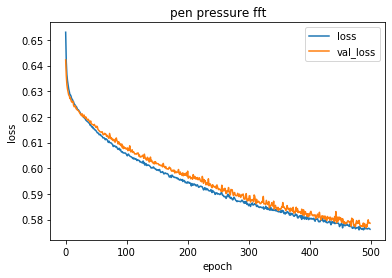

In [18]:
plt.title('pen pressure fft')
plt.plot(np.arange(len(history.history['loss'])), history.history['loss'],label='loss')
plt.plot(np.arange(len(history.history['val_loss'])), history.history['val_loss'],label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

36182/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

              precision    recall  f1-score   support

       No PD       0.70      0.59      0.64     17117
          PD       0.68      0.77      0.72     19065

    accuracy                           0.69     36182
   macro avg       0.69      0.68      0.68     36182
weighted avg       0.69      0.69      0.68     36182



0.6852025869216738

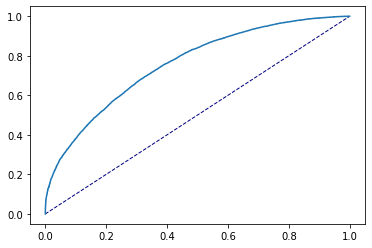

In [13]:
def eval_score(model, X_test, y_test, THRESHOLD = 0.5, report = False):
    y_pred = model.predict(X_test, batch_size=64, verbose=1).reshape(-1)
    y_pred_bool = np.where(y_pred < THRESHOLD, 0, 1)
    if report:
        print(classification_report(y_test, y_pred_bool, target_names=['No PD', 'PD']))
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.plot(fpr, tpr)
        
    acc = accuracy_score(y_test, y_pred_bool)
    return acc

eval_score(model, X_test, y_test, report=True)

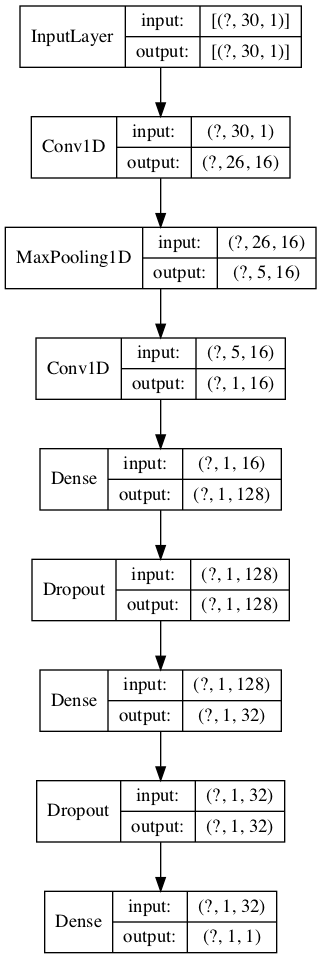

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=False, to_file='model.png')

In [28]:
X_test[0]

array([[ 5.18160185+0.j        ],
       [-0.55533673-1.70954251j],
       [-2.65807229+0.49623811j],
       [-1.01506873-0.41111579j],
       [-2.62921515+0.70197744j],
       [-1.55681904-0.50238838j],
       [-2.07830956+0.49716854j],
       [-1.93097308-0.75037352j],
       [-1.29042696-0.31351796j],
       [-1.36417908-0.44691064j],
       [-1.14088264-0.5662008j ],
       [-0.69991407-0.80335811j],
       [-0.62299793-0.3327078j ],
       [-0.59425358-0.83020791j],
       [-0.30628239-0.61052249j],
       [-0.09759442-0.6058128j ],
       [-0.22374191-0.5262996j ],
       [ 0.17015653-0.72540116j],
       [ 0.16797841-0.46027014j],
       [ 0.26103409-0.57008541j],
       [ 0.33200715-0.54162088j],
       [ 0.48937958-0.45209528j],
       [ 0.38337496-0.41602515j],
       [ 0.49166835-0.41471114j],
       [ 0.46946745-0.31900345j],
       [ 0.47668571-0.29817295j],
       [ 0.48596085-0.24617751j],
       [ 0.50392553-0.19309087j],
       [ 0.44661213-0.12490652j],
       [ 0.448